In [2]:
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns
import numpy as np
import json

plt.style.use('seaborn-ticks')

/tmp/ipykernel_3959963/2887630075.py:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-ticks')


# Merge all results

In [3]:
models = [
    'vicuna-7b-v1.5',
    'vicuna-13b-v1.5',
    'vicuna-33b-v1.3',
    
    'mpt-7b',
    'mpt-30b',
    
    'falcon-7b',
    'falcon-40b',
   
    
    'Llama-2-7b-hf',
    'Llama-2-13b-hf',
    'Llama-2-7b-chat-hf',
    'Llama-2-13b-chat-hf',
]

In [4]:
dfs = []
config_dfs = []
for model in models:
    vanilla = json.load(open(f'./merged_eval_results/greedy/{model}_with_sys_prompt_summary.json', 'r'))
    data = json.load(open(f'./merged_eval_results/exploited/{model}_summary.json', 'r'))
    data_cp = {'model': model, 'vanilla': vanilla['greedy']}
    config_cp = {'model': model}
    for (k,v) in data.items():
        if k != 'best_attack_config':
            data_cp[k] = v
        else:
            for kk, vv in v.items():
                config_cp[kk] = (list(vv.keys())[0].split('_')[1], list(vv.values())[0])
    dfs.append(pd.DataFrame([data_cp]))
    config_dfs.append(pd.DataFrame([config_cp]))
pd.concat(dfs)

,model,vanilla,default,break_by_temp,break_by_topk,break_by_topp,break_by_all
0,vicuna-7b-v1.5,50,62,92,95,95,97
0,vicuna-13b-v1.5,21,55,95,90,94,97
0,vicuna-33b-v1.3,42,50,94,94,93,96
0,mpt-7b,0,86,94,95,95,97
0,mpt-30b,0,91,95,96,97,98
0,falcon-7b,5,75,95,92,95,95
0,falcon-40b,7,72,95,93,94,95
0,Llama-2-7b-hf,14,85,94,93,96,97
0,Llama-2-13b-hf,34,83,96,95,96,97
0,Llama-2-7b-chat-hf,0,16,59,57,71,81


In [5]:
pd.concat(config_dfs)

,model,temp,topk,topp
0,vicuna-7b-v1.5,"(0.3, 62)","(1, 62)","(0.4, 64)"
0,vicuna-13b-v1.5,"(0.8, 56)","(1, 54)","(0.25, 57)"
0,vicuna-33b-v1.3,"(0.8, 59)","(50, 56)","(0.6, 59)"
0,mpt-7b,"(0.1, 83)","(1, 85)","(0.05, 83)"
0,mpt-30b,"(0.1, 87)","(1, 86)","(0.3, 88)"
0,falcon-7b,"(0.2, 78)","(1, 75)","(0.25, 80)"
0,falcon-40b,"(0.25, 79)","(5, 75)","(0.3, 78)"
0,Llama-2-7b-hf,"(0.45, 85)","(1, 83)","(0.2, 85)"
0,Llama-2-13b-hf,"(0.5, 85)","(1, 83)","(0.3, 87)"
0,Llama-2-7b-chat-hf,"(0.95, 25)","(500, 26)","(0.7, 29)"


## Sampling

In [6]:
dfs = []
model = 'Llama-2-13b-chat-hf'
for n_sample in range(1, 9):
    if n_sample > 1:
        data = json.load(open(f'./merged_eval_results/exploited/{model}_sample_{n_sample}_summary.json', 'r'))
    else:
        data = json.load(open(f'./merged_eval_results/exploited/{model}_summary.json', 'r'))
    data_cp = {'model': model, 'n_sample': n_sample}
    for (k,v) in data.items():
        if k != 'best_attack_config':
            data_cp[k.split('_')[-1]] = int(v)
    dfs.append(pd.DataFrame([data_cp]))
res_13b = pd.concat(dfs)

In [7]:
dfs = []
model = 'Llama-2-7b-chat-hf'
for n_sample in range(1, 9):
    if n_sample > 1:
        data = json.load(open(f'./merged_eval_results/exploited/{model}_sample_{n_sample}_summary.json', 'r'))
    else:
        data = json.load(open(f'./merged_eval_results/exploited/{model}_summary.json', 'r'))
    data_cp = {'model': model, 'n_sample': n_sample}
    for (k,v) in data.items():
        if k != 'best_attack_config':
            data_cp[k.split('_')[-1]] = int(v)
    dfs.append(pd.DataFrame([data_cp]))
res_7b = pd.concat(dfs)
res_7b[res_7b==94] = 95

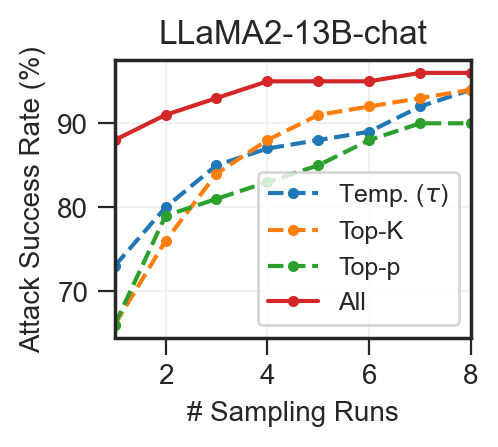

: 

In [26]:
plt.figure(figsize=(2.3, 1.8), dpi=200)
names = {
    'temp': r'Temp. ($\tau$)',
    'topk': 'Top-K',
    'topp': 'Top-p',
    'all': 'All'
}
for key in ['temp', 'topk', 'topp', 'all']:
    if key != 'all':
        ls = '--'
    else:
        ls = '-'
    plt.plot(res_13b['n_sample'].values, res_13b[key].values, label=names[key], marker='.', ls=ls)
plt.legend(fontsize=9, frameon=True)
plt.xlabel('# Sampling Runs')
plt.ylabel('Attack Success Rate (%)')
plt.title('LLaMA2-13B-chat')
plt.xlim(1,8)
plt.grid(c="0.95")
plt.savefig(f"figures/n_sample_13B.pdf", format="pdf", bbox_inches="tight")

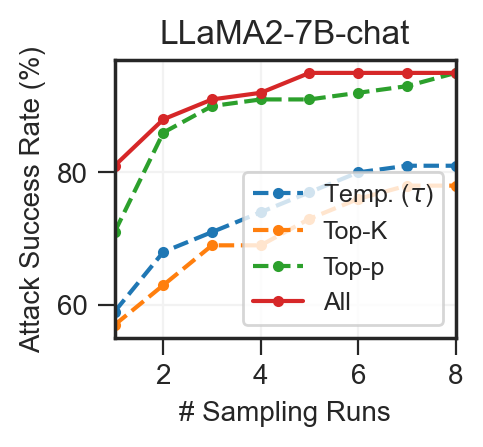

In [24]:
plt.figure(figsize=(2.3, 1.8), dpi=200)
names = {
    'temp': r'Temp. ($\tau$)',
    'topk': 'Top-K',
    'topp': 'Top-p',
    'all': 'All'
}
for key in ['temp', 'topk', 'topp', 'all']:
    if key != 'all':
        ls = '--'
    else:
        ls = '-'
    plt.plot(res_7b['n_sample'].values, res_7b[key].values, label=names[key], marker='.', ls=ls)
plt.legend(fontsize=9, frameon=True)
plt.xlabel('# Sampling Runs')
plt.ylabel('Attack Success Rate (%)')
plt.title('LLaMA2-7B-chat')
plt.xlim(1,8)
plt.grid(c="0.95")
plt.savefig(f"figures/n_sample_7B.pdf", format="pdf", bbox_inches="tight")